In [100]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

LOAD THE DATA 

In [101]:
# Load dataset saved from data evaluation
df = pd.read_csv("explored_data.csv")

print(f"✅ Loaded dataset with shape: {df.shape}")
df.head()


✅ Loaded dataset with shape: (2216, 30)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Costumer_for
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,0,3,11,1,57283200000000000
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,0,3,11,0,9763200000000000
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,3,11,0,26956800000000000
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,0,3,11,0,12009600000000000
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,0,3,11,0,13910400000000000


# 🛠 Feature Engineering

In this section, I will be performing the following steps to engineer new features:

* Extract the **"Age"** of a customer by the **"Year_Birth"** indicating the birth year of the respective person.
* Create another feature **"Spent"** indicating the total amount spent by the customer in various categories over the span of two years.
* Create another feature **"Living_With"** out of **"Marital_Status"** to extract the living situation of couples.
* Create a feature **"Children"** to indicate total children in a household that is, kids and teenagers.
* To get further clarity of household, creating feature indicating **"Family_Size"**.
* Create a feature **"Is_Parent"** to indicate parenthood status.
* Lastly, I will create three categories in the **"Education"** by simplifying its value counts.
* Dropping some of the redundant features that are no longer needed.


In [102]:
#create features
#1) age from birth

df['age '] = 2025 - df['Year_Birth']

#total spend on various items
spending_cols =['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts',"MntGoldProds"]
df['total_spend'] = df[spending_cols].sum(axis=1)

#living with feature from marital status 
df['living_with'] = df["Marital_Status"].replace({
    'Married': "Partner",
    "Single": "Alone",
    "Divorced":"Alone",
    "YOLO": "Alone",
    "Widow":"Alone",
    "Absurd":"Alone",
    'Together':'Partner'

})

#children (kids + teengager)
df['Children'] = df["Kidhome"] + df['Teenhome']

#total family size
df['Family_Size'] = df['Children'] + df['living_with'].replace({"Alone": 1, "Partner": 2})

#is_parent(binary_feature)
#👉 So, Is_Parent is just a binary feature (flag) that tells you if the customer is a parent or not, based on the Children column.
df['is_parent'] = np.where(df.Children >0,1,0)

#simpify eduactions
df["Education"] = df['Education'].replace({
    'Basic' : 'Undergraduate',
    "2n cycle": "Undergraduate",
    "Graduation": "Graduate",
    "Master":"Postgraduate",
    "PhD": "Postgraduate"

})

In [103]:
#Simply rename the long column names from the dataset into shorter, easier-to-read ones
df = df.rename(columns={
    "MntWines": "Wines",
    "MntFruits": "Fruits",
    "MntMeatProducts": "Meat",
    "MntFishProducts": "Fish",
    "MntSweetProducts": "Sweets",
    "MntGoldProds": "Gold"
})


🔎 Why these will be dropped:

Marital_Status → already simplified into "Living_With".

Dt_Customer → already transformed into "Customer_for" (days since enrollment).

Z_CostContact & Z_Revenue → these have no variability (constant for all customers in this dataset).

Year_Birth → converted into "Age".

ID → identifier, not useful for clustering or ML.

In [104]:
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)



In [105]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Costumer_for,age,total_spend,Children,Family_Size,is_parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,56.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,29.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,48.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,55.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,66.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,132.000000,2525.000000,3.000000,5.000000,1.000000


### Exploratory Visualization of Selected Features  

After performing feature engineering, it is useful to explore the **distribution of key features** in the dataset.  

In this step, I will plot the following features:  

- **Income** → annual household income of customers  
- **Recency** → days since last purchase  
- **Customer_For** → number of days the customer has been with the company  
- **Age** → age of the customer  
- **Spent** → total spending across product categories  
- **Is_Parent** → binary indicator if the customer has children  

The plots will help:  
- Detect **outliers** (e.g., unusually high income or extreme ages)  
- Understand **skewness** and distribution of numerical features  
- Visualize the balance of **categorical/binary features** like parenthood  

This broader view will allow me to validate earlier observations (e.g., unrealistic ages like 128 years, high-income outliers) before moving forward with deeper analysis.  


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

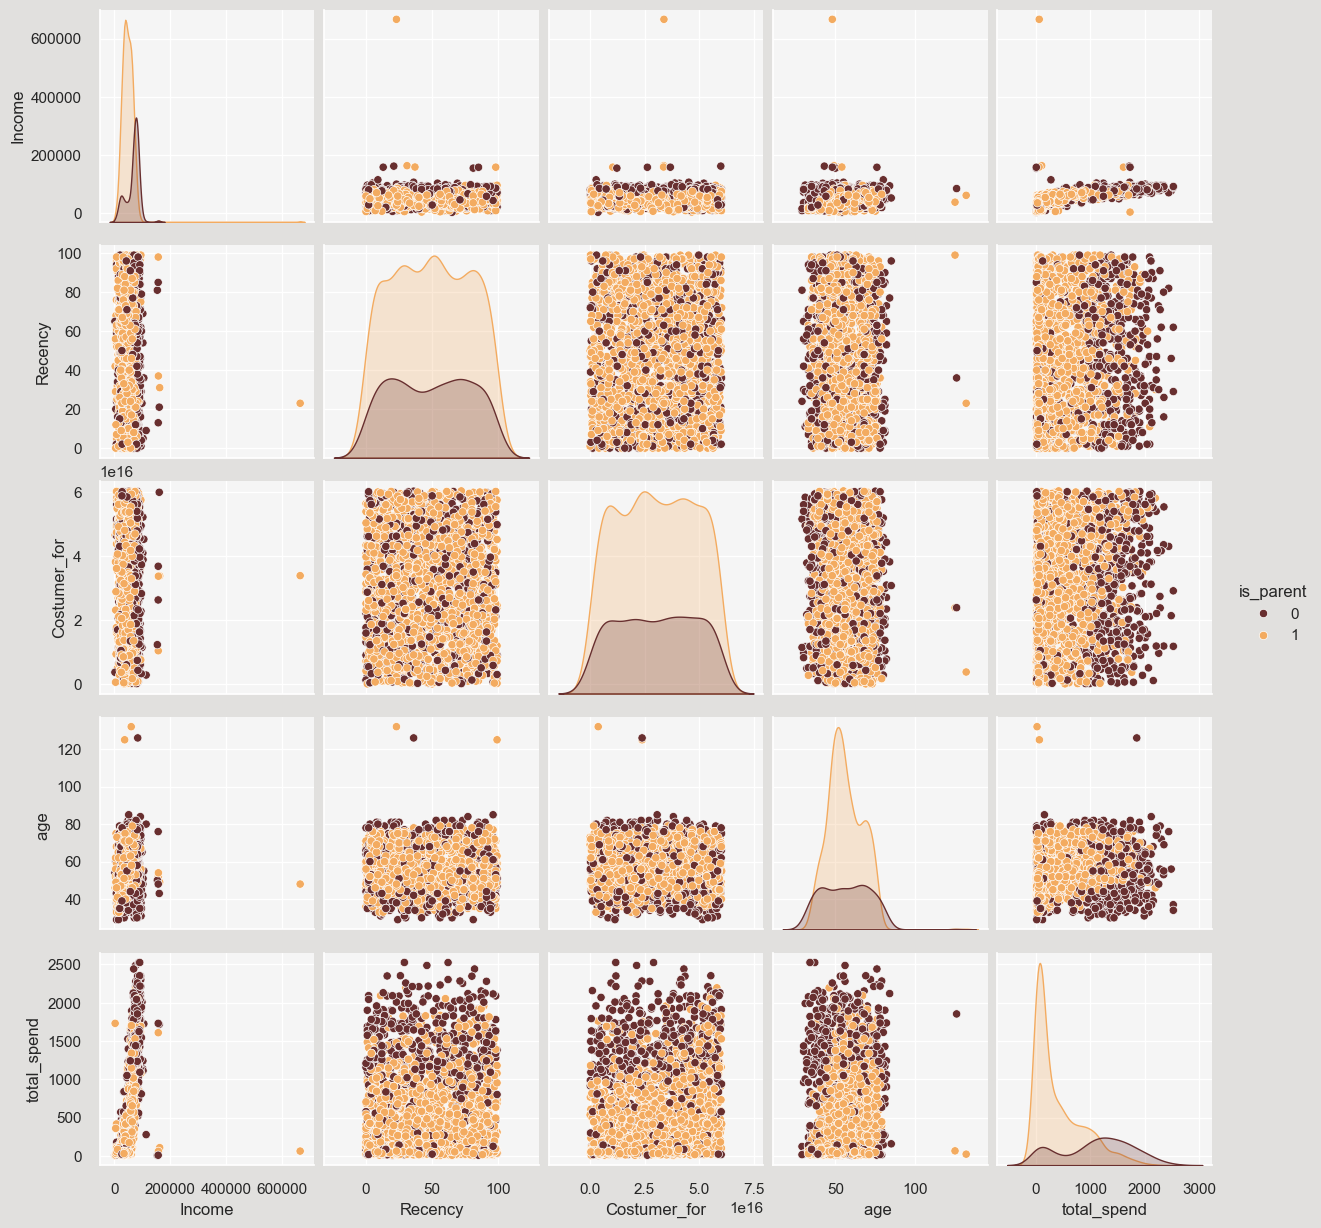

In [106]:
#setting up color preference
sns.set(rc={'axes.facecolor':"#F5F5F5", 'figure.facecolor': "#DAD9D6CA"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(pallet)

# Features to plot
To_Plot = ["Income", "Recency", "Costumer_for", "age ", "total_spend", "is_parent"]

print("Relative Plot Of Some Selected Features: A Data Subset")

plt.figure()
sns.pairplot(df[To_Plot], hue= "is_parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [107]:
#removing outliers
df = df[(df["age "] < 90)]
df = df[(df["Income"] < 600000)]

print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2212


checking how features relate to each other

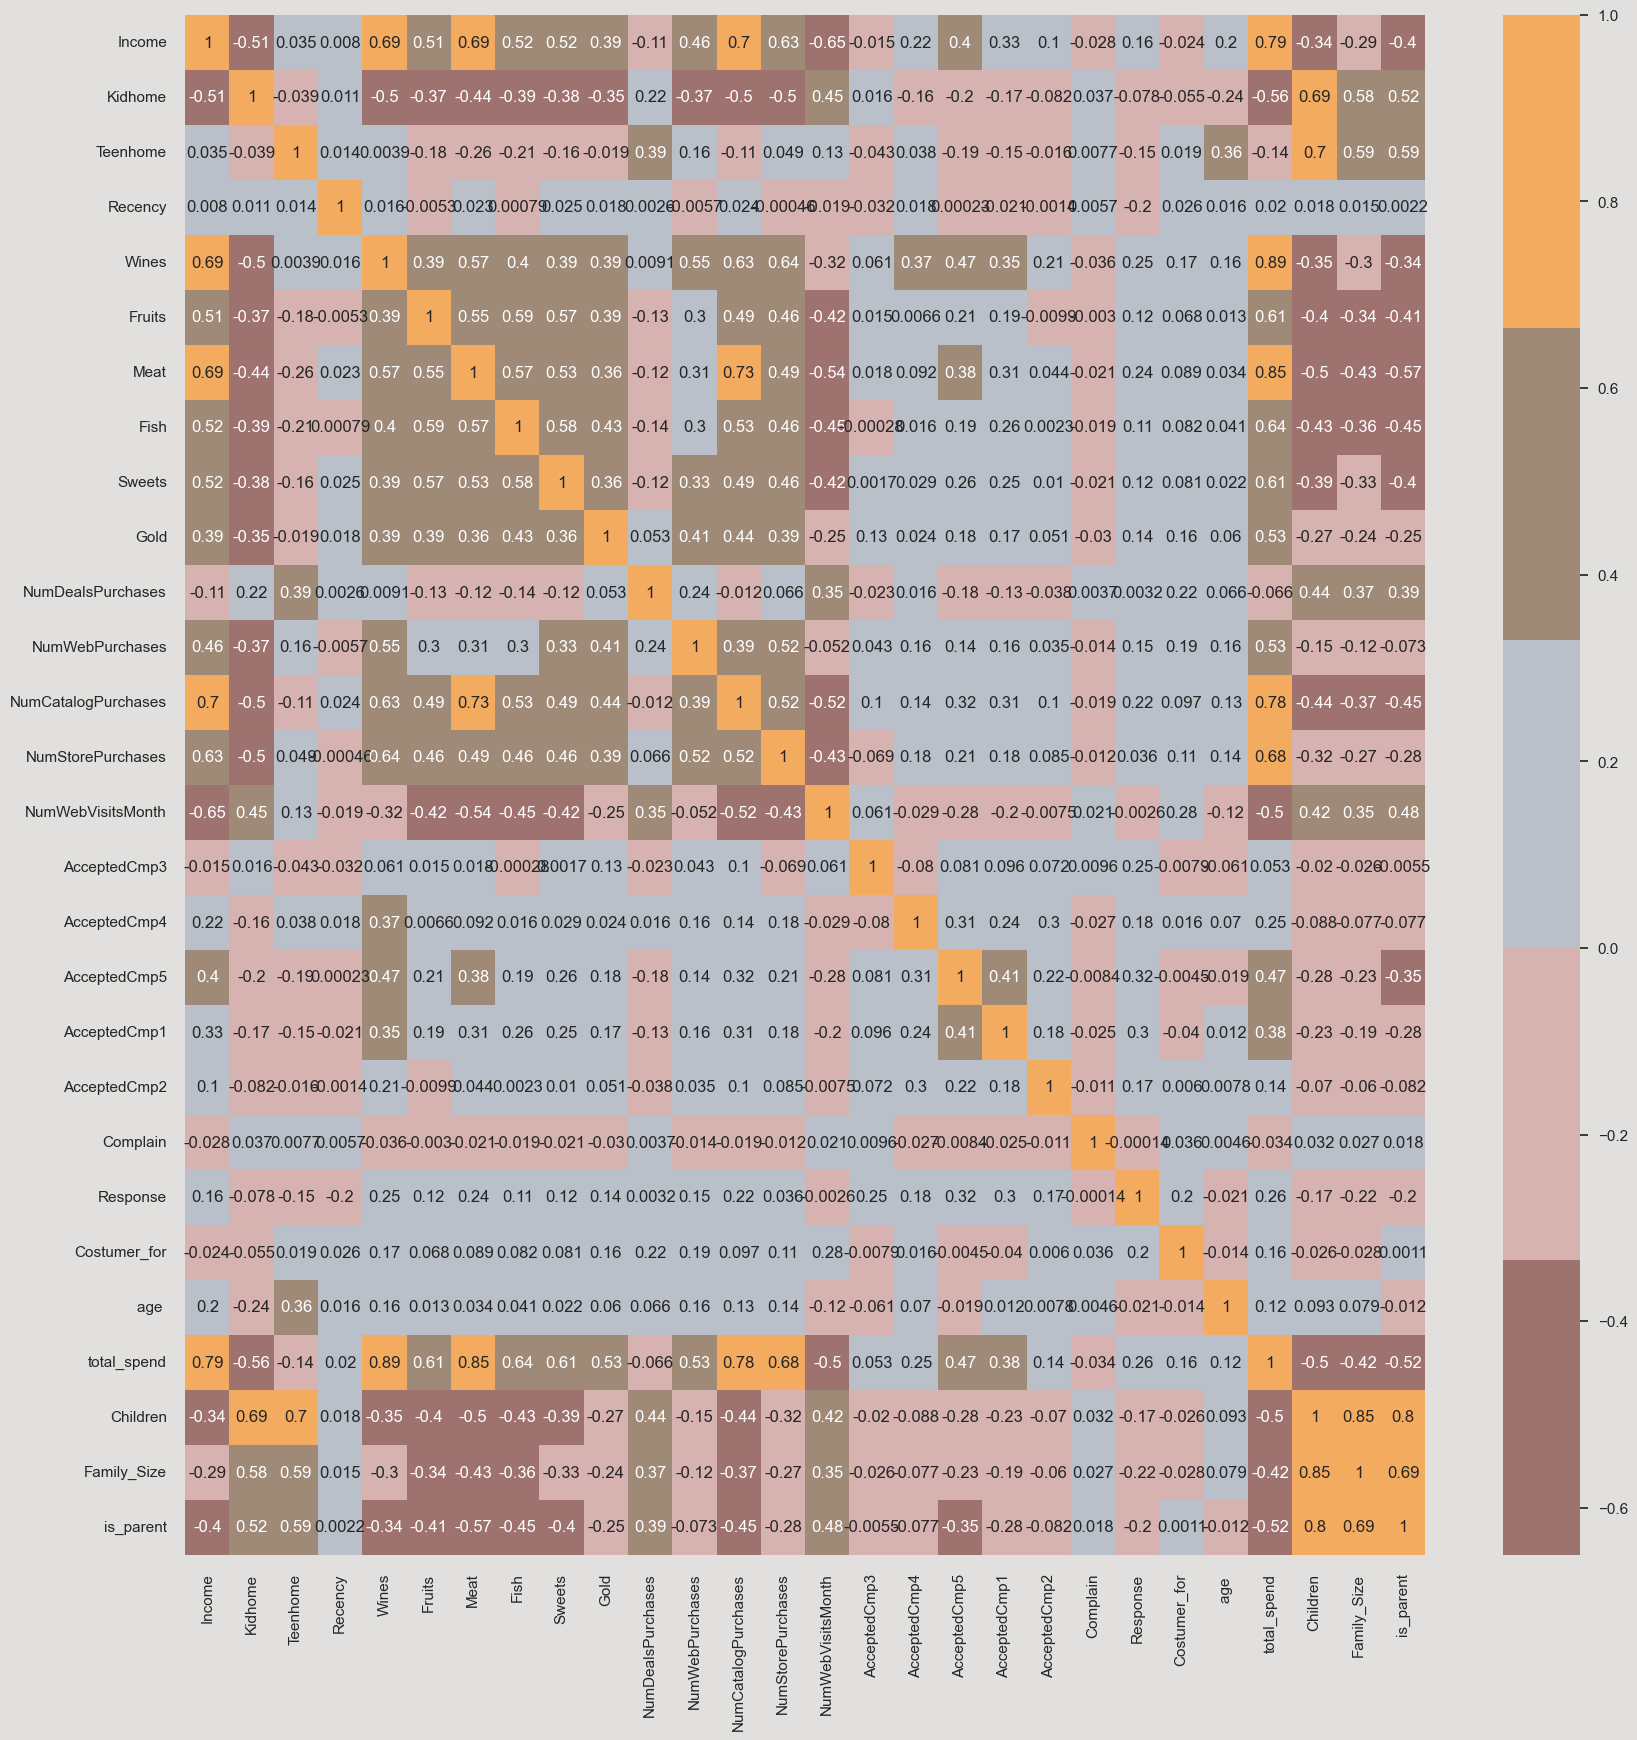

In [108]:
# Select only numeric columns
numeric_data = df.select_dtypes(include=[np.number])

# Correlation matrix
corrmat = numeric_data.corr()

plt.figure(figsize=(20,20))  
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)
plt.show()


In [109]:
df.to_csv("feature_engineered_data.csv", index=False)
print("✅ Feature engineering complete. Data saved as 'feature_engineered_data.csv'")


✅ Feature engineering complete. Data saved as 'feature_engineered_data.csv'


🎯 Result

After running this notebook, you will have:

Age of customers

Spent (total spend across categories)

Living_With (Partner / Alone)

Children (kids + teens)

Family_Size (better household clarity)

Is_Parent (parenthood binary flag)

Simplified Education (3 categories only)

Dropped redundant columns